In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from matplotlib import pyplot as plt
from scipy.stats import boxcox
# from statsmodels.stats.diagnostic import het_breuschpagan

np.random.seed(21)
df_train = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/2016_cleaned.csv')

target = 'logerror'
pid = 'parcelid'

plt.style.use('seaborn-darkgrid') # Set Plotting Aesthetic Defaults
%matplotlib inline

In [34]:
_, l = boxcox(df_train.logerror + np.abs(df_train.logerror.min()) + .000001) 
print(f'Y Box-Cox lambda: {l:.3f}')

Y Box-Cox lambda: 0.970


In [35]:
continuous_cols = ['bedroomcnt','buildingqualitytypeid','calculatedbathnbr','calculatedfinishedsquarefeet','fireplacecnt','lotsizesquarefeet','poolcnt','roomcnt','unitcnt','yearbuilt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt']

for i in continuous_cols:
    print(i)
    var = df_train.loc[:, i]
    
    if var.min() <= 0:
        
        var = var + np.abs(var.min()) + .000001
        df_train.loc[:, i] = df_train.loc[:, i] + np.abs(df_train.loc[:, i].min()) + .000001
        
    _, l = boxcox(var) 
    
    df_train.loc[:, i] = np.power(df_train.loc[:, i], l)
    
    print(f' Box-Cox Transformed lambda: {l:.3f}')

bedroomcnt
 Box-Cox Transformed lambda: 0.680
buildingqualitytypeid
 Box-Cox Transformed lambda: 1.457
calculatedbathnbr
 Box-Cox Transformed lambda: 0.215
calculatedfinishedsquarefeet
 Box-Cox Transformed lambda: -0.149
fireplacecnt
 Box-Cox Transformed lambda: -0.670
lotsizesquarefeet
 Box-Cox Transformed lambda: -0.395
poolcnt
 Box-Cox Transformed lambda: -0.349
roomcnt
 Box-Cox Transformed lambda: -0.258
unitcnt
 Box-Cox Transformed lambda: -6.172
yearbuilt
 Box-Cox Transformed lambda: 11.583
structuretaxvaluedollarcnt
 Box-Cox Transformed lambda: 0.057
landtaxvaluedollarcnt
 Box-Cox Transformed lambda: 0.118


In [36]:
def run_multiple_regression_ols(df, X_list, print_output = False):

    X = sm.add_constant(df.loc[:, X_list]) # Predictor Matrix: IV + Constant
    y = df.Y # Prediction Targets

    # Fit, summarize OLS regression
    model = sm.OLS(y, X)
    result = model.fit()
    
    if print_output == True:
        
        print(result.summary())
        
    resids = result.resid
    preds = result.predict(X)
    
    return result, resids, preds

def backward_regression(X, 
                        y,
                        initial_list=[], 
                        threshold_in=0.01, 
                        threshold_out = 0.05, 
                        verbose=True):
    included=list(X.columns)
    i = 1
    while True:
        i += 1
        changed=False
        #print(X[included].dtypes)
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(worst_feature, '   ',str(worst_pval))
                #print('Drop  with p-value '.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def normal_probability_plot(result, resids):
    
    resid_df = pd.DataFrame(resids, columns = ['resid'])
    resid_df = resid_df.sort_values(by = 'resid').reset_index(drop = True).reset_index().rename({'index':'k'}, axis = 1)
    resid_df.k = resid_df.k + 1
    resid_df['expected_value'] = resid_df.apply(lambda x: np.sqrt(result.mse_resid) * scipy.stats.norm().ppf((x.k - .375)/(len(resid_df) + .25)), axis = 1)

    fig = plt.scatter(resid_df.expected_value, resid_df.resid)

    plt.xlabel('Expected')
    plt.ylabel('Residual')
    plt.title('Normal Probability Plot')
    
    plt.show()

In [38]:
drop_cols = ['fips_6111.0','heatingorsystemtypeid_24.0','regionidcity_9840.0','propertylandusetypeid_275.0','propertycountylandusecode_96','assessmentyear','yearbuilt']
df_train['Y'] = df_train.logerror
training_cols = [i for i in df_train.columns if i not in [pid, target,'transactiondate','Y','census_tract','censustractandblock']]
training_cols = [i for i in training_cols if i not in drop_cols]

In [39]:
full_model_result, resids, preds = run_multiple_regression_ols(df_train, training_cols, True)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.054
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          1.77e-142
Time:                        23:07:40   Log-Likelihood:                 37519.
No. Observations:               89670   AIC:                        -7.450e+04
Df Residuals:                   89402   BIC:                        -7.198e+04
Df Model:                         267                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

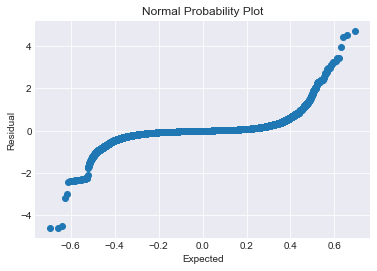

In [8]:
normal_probability_plot(result, resids)

In [30]:
backward_X = df_train[training_cols]
backward_y = df_train['logerror']
backwards_test = backward_regression(backward_X, backward_y, verbose = True)

regionidcity_46178.0     0.9849722903782283
regionidcity_40110.0     0.9820397952566908
regionidcity_33612.0     0.9717278155663427
regionidcity_53571.0     0.965797812502835
regionidcity_25459.0     0.9798105993393307
regionidcity_33727.0     0.9578520774105688
regionidcity_113576.0     0.9476731094227178
heatingorsystemtypeid_13.0     0.9474874680400109
regionidcity_15554.0     0.9352652730252139
regionidcity_45457.0     0.934817929440152
propertycountylandusecode_1310     0.9336673225109144
regionidcity_21412.0     0.9261979885595363
regionidcity_25458.0     0.9230125213225662
regionidcity_34780.0     0.9228679056334523
regionidcity_10815.0     0.9216447409440558
regionidcity_11626.0     0.9177655573625114
regionidcity_396556.0     0.9038467200019289
regionidcity_44116.0     0.9023771559025401
regionidcity_42150.0     0.9012598803105379
regionidcity_26483.0     0.9005883870304736
regionidcity_33252.0     0.8974779811853677
heatingorsystemtypeid_11.0     0.8882804673948097
regionidci

In [31]:
X = sm.add_constant(df_train.loc[:, backwards_test]) # Predictor Matrix: IV + Constant
y = df_train.Y # Prediction Targets

# Fit, summarize OLS regression
backwards_model = sm.OLS(y, X)
backwards_model_result = backwards_model.fit()
backwards_model_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     14.88
Date:                Mon, 11 Apr 2022   Prob (F-statistic):          2.11e-193
Time:                        22:56:20   Log-Likelihood:                 37432.
No. Observations:               89670   AIC:                        -7.470e+04
Df Residuals:                   89590   BIC:                        -7.395e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              1.1487      0.098     11.723      0.000       0.957       1.341
calculatedbathnbr                  0.0349      0.009      3.863      0.000       0.017       0.053
calculatedfinishedsquarefeet      -0.3478      0.050     -6.951      0.000      -0.446      -0.250
fireplacecnt                    4.755e-07   1.88e-07      2.534      0.011    1.08e-07    8.43e-07
hashottuborspa                    -0.0103      0.003     -2.972      0.003      -0.017      -0.004
structuretaxvaluedollarcnt        -0.0384      0.011     -3.632      0.000      -0.059      -0.018
landtaxvaluedollarcnt             -0.0040      0.001     -2.925      0.003      -0.007      -0.001
regionidcity_3491.0                0.2329      0.029      7.988      0.000       0.176       0.290
regionidcity_5534.0               -0.0117      0.004     -3.115      0.002      -0.019      -0.004
regionidcity_6822.0                0.1339      0.033      4.108      0.000       0.070       0.198
regionidcity_10389.0              -0.0363      0.011     -3.410      0.001      -0.057      -0.015
regionidcity_14906.0              -0.0976      0.044     -2.205      0.027      -0.184      -0.011
regionidcity_16389.0               0.0576      0.027      2.163      0.031       0.005       0.110
regionidcity_17686.0              -0.0170      0.008     -2.024      0.043      -0.034      -0.001
regionidcity_18875.0               0.0689      0.022      3.200      0.001       0.027       0.111
regionidcity_19177.0              -0.0318      0.009     -3.674      0.000      -0.049      -0.015
regionidcity_20008.0               0.0175      0.006      2.975      0.003       0.006       0.029
regionidcity_21778.0               0.0461      0.023      2.040      0.041       0.002       0.090
regionidcity_22827.0               0.0316      0.009      3.385      0.001       0.013       0.050
regionidcity_25468.0               0.0619      0.031      2.013      0.044       0.002       0.122
regionidcity_27183.0              -0.0353      0.013     -2.702      0.007      -0.061      -0.010
regionidcity_29712.0              -0.0245      0.012     -1.995      0.046      -0.049      -0.000
regionidcity_30267.0               0.0461      0.018      2.531      0.011       0.010       0.082
regionidcity_31134.0              -0.2130      0.046     -4.625      0.000      -0.303      -0.123
regionidcity_33837.0               0.0223      0.010      2.282      0.022       0.003       0.041
regionidcity_36502.0               0.1053      0.023      4.524      0.000       0.060       0.151
regionidcity_37015.0               0.0316      0.009      3.676      0.000       0.015       0.048
regionidcity_39306.0               0.0309      0.013      2.320      0.020       0.005       0.057
regionidcity_4

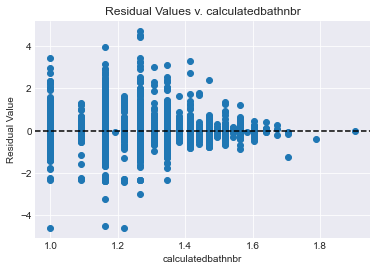

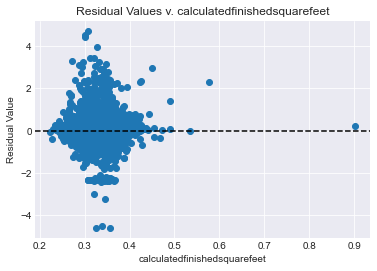

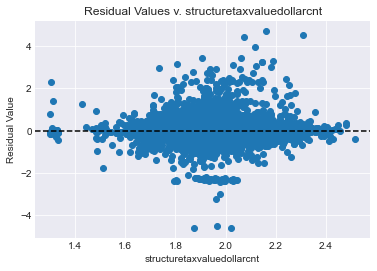

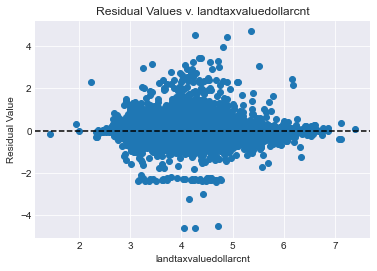

In [32]:
def plot_resid_pred(model, pred):
    resid = model.resid
    plt.scatter(pred, resid)
    plt.xlabel(pred.name)
    plt.ylabel('Residual Value')
    plt.title('Residual Values v. ' + pred.name)
    plt.axhline(color = 'black', linestyle = 'dashed')
    plt.show()

pred_columns = ['calculatedbathnbr',
'calculatedfinishedsquarefeet',
'structuretaxvaluedollarcnt',
'landtaxvaluedollarcnt']

for column in pred_columns:
    plot_resid_pred(backwards_model_result, X[column])

In [51]:
def partial_f_test(full_model, red_model, a):
    test_stat = red_model.mse_model / full_model.mse_resid
    p_val = scipy.stats.f.ppf(1-a, full_model.df_model - red_model.df_model, full_model.nobs - full_model.df_model)
    if test_stat >= p_val: 
        reject = True
    else:
        reject = False
    return test_stat, p_val, reject

partial_f_test(full_model_result, backwards_model_result, a = 0.05)

(14.877394727609634, 1.1757130407912195, True)

In [79]:
backwards_model_params = pd.DataFrame({'param_name' : backwards_model_result.params.index,"params" : backwards_model_result.params})
backwards_model_params['param_name'] = backwards_model_params['param_name'].astype(str) 
sig_regions = backwards_model_params[backwards_model_params['param_name'].str.contains('regionid')]
sig_regions.param_name.str.split("_")

param_name     object
params        float64
dtype: object


regionidcity_3491.0        [regionidcity, 3491.0]
regionidcity_5534.0        [regionidcity, 5534.0]
regionidcity_6822.0        [regionidcity, 6822.0]
regionidcity_10389.0      [regionidcity, 10389.0]
regionidcity_14906.0      [regionidcity, 14906.0]
regionidcity_16389.0      [regionidcity, 16389.0]
regionidcity_17686.0      [regionidcity, 17686.0]
regionidcity_18875.0      [regionidcity, 18875.0]
regionidcity_19177.0      [regionidcity, 19177.0]
regionidcity_20008.0      [regionidcity, 20008.0]
regionidcity_21778.0      [regionidcity, 21778.0]
regionidcity_22827.0      [regionidcity, 22827.0]
regionidcity_25468.0      [regionidcity, 25468.0]
regionidcity_27183.0      [regionidcity, 27183.0]
regionidcity_29712.0      [regionidcity, 29712.0]
regionidcity_30267.0      [regionidcity, 30267.0]
regionidcity_31134.0      [regionidcity, 31134.0]
regionidcity_33837.0      [regionidcity, 33837.0]
regionidcity_36502.0      [regionidcity, 36502.0]
regionidcity_37015.0      [regionidcity, 37015.0]
